In [11]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D,Wraparound1D,periodic_padding,CustomCallback,CustomCallbackAcc
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
def get_model(): 
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  
    model.add(Wraparound1D(padding=1))
    model.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',  trainable=True,
                                     bias_initializer=tf.keras.initializers.Zeros()) )

    model.add(tf.keras.layers.Conv1D(10, 1, activation='relu', padding='same',
                                    bias_initializer=tf.keras.initializers.Zeros()))

    model.add(tf.keras.layers.Dense(units=2, activation="softmax",
                                    bias_initializer=tf.keras.initializers.Zeros()))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
                  ,loss=loss, metrics=['accuracy'])
    return model
def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length,1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
        if logs.get('val_accuracy') == 1:
            self.model.stop_training = True 

def balance_dataset(sequences):
    print(sequences.shape)
    count_ones = np.sum(sequences[:,-1:,:] == 1)
    count_zeros = np.sum(sequences[:,-1:,:] == 0)
    print(count_ones)
    print(count_zeros)
    ratio = count_zeros / count_ones 
    print(ratio)
    while ratio > 6 and len(x_train) > 0:
        print(ratio)
        for index,row in enumerate(sequences):
            row =row[1]
            zeros_per_row = np.sum(row == 0)
            ones_per_row = np.sum(row == 1)
            print(f"Ones per row: {ones_per_row}, Zeros per row: {zeros_per_row}")
            if( zeros_per_row >7):
                row_to_remove = np.argmax(zeros_per_row - ones_per_row)
                print(f"removing {index}")
                sequences = np.delete(sequences, index, axis=0)
                count_ones = np.sum(sequences[:,-1:,:] == 1)
                count_zeros = np.sum(sequences[:,-1:,:] == 0)
                ratio = count_zeros / count_ones 
                break
                
    return sequences



def split_dataset(x,y):
        split_ratio=0.25
        split_point_x = int(len(x) * split_ratio)
        split_point_y = int(len(y) * split_ratio)

        x_test = x[:split_point_x]
        y_test = y[:split_point_y]
        x_train = x[split_point_x:]
        y_train = y[split_point_y:]
        split_ratio = 0.5

        split_point_x = int(len(x_test) * split_ratio)
        split_point_y = int(len(y_test) * split_ratio)


        x_val = x_test[:split_point_x]
        y_val = y_test[:split_point_x]
        x_test = x_test[split_point_x:]
        y_test = y_test[split_point_x:]
        return  (x_train,y_train,x_val,y_val,x_test,y_test)


gridsize=10
 
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]
x_values = [[int(bit) for bit in seq] for seq in x_values]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


x_train shape: (768, 1, 10) y_train shape: (768, 10, 2) x_val shape: (128, 1, 10) y_val shape: (128, 10, 2) x_test shape: (128, 1, 10) y_test shape: (128, 10, 2)


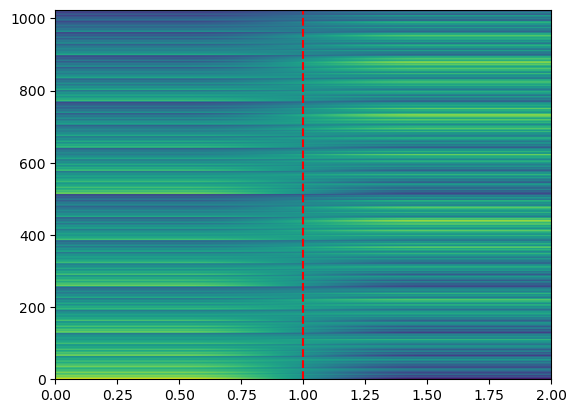

In [2]:
MEMORY_CONSTANT=1
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

ca.set_rule_number(30)

sequences= np.array(ca.generate_training_data_sequences(x_values,sequence_length=sequence_length-1))

#sequences=balance_dataset(sequences)
 

collapsed_sequences=collapse_sequences(sequences)
collapsed_sequences_2d = np.squeeze(collapsed_sequences, axis=-1)
plt.imshow(collapsed_sequences_2d, cmap='viridis', origin='upper',
           extent=[0, collapsed_sequences_2d.shape[1], 0, collapsed_sequences_2d.shape[0]],
           aspect='auto', vmin=0, vmax=gridsize)
for x in range(1, collapsed_sequences_2d.shape[1]):
    plt.axvline(x=x, color='red', linestyle='--')

np.random.shuffle(sequences)
x_sequence=sequences[:,MEMORY_CONSTANT-1:(MEMORY_CONSTANT)*2-1,:]
y_sequence=sequences[:,-1,:]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
x_train = x_sequence   
y_train= Y_val_onehot

x_train,y_train,x_val,y_val,x_test,y_test=split_dataset(x_train,y_train)
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape, "x_val shape:", x_val.shape, "y_val shape:", y_val.shape, "x_test shape:", x_test.shape, "y_test shape:", y_test.shape)


# Regular 1D CA learned by a modified versison of the CNN-NIN architecture


In [3]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape, "x_val shape:", 
      x_val.shape, "y_val shape:", y_val.shape, "x_test shape:", x_test.shape, "y_test shape:", y_test.shape)


count_ones_x = np.sum(y_test == 1)
count_zeros_x = np.sum(y_test == 0)

count_ones_x, count_zeros_x
memory_horizon=MEMORY_CONSTANT 
loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),
                                tf.reshape(y, shape=(-1, num_classes)),  from_logits=True)

model =get_model()

model.summary()
early_stopping_callback = CustomCallback()
 
x_train_reshaped=x_train.reshape(-1, gridsize,1)
model.fit(x_train_reshaped, y_train, 
          validation_data=(x_val.reshape(-1,gridsize,1 ), y_val),epochs=3
        , batch_size=1,callbacks=[early_stopping_callback]) 
accuracy=model.evaluate(x_test.reshape(-1, gridsize,1),y_test)
print(accuracy)


x_train shape: (768, 1, 10) y_train shape: (768, 10, 2) x_val shape: (128, 1, 10) y_val shape: (128, 10, 2) x_test shape: (128, 1, 10) y_test shape: (128, 10, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound1d (Wraparound1D)  (None, 12, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 10, 10)            40        
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 10)            110       
                                                                 
 dense (Dense)               (None, 10, 2)             22        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
4/4 [=============

In [4]:
predictions=model.predict(x_train_reshaped)
#np.argmax(predictions[0],axis=1)
#preds=np.array(list(map(lambda x:np.round(x,axis=1),predictions))).squeeze()
#true=np.array(list(map(lambda x:np.argmax(x,axis=1),y_test))).squeeze()
index=1
for ind,prediction in enumerate(x_train_reshaped):
    print(np.argmax(prediction,axis=1))
    print(np.argmax(y_train[ind],axis=1))
    print("__________")
    
indices

24/24 [==============================] - 0s 826us/step
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 0 0 1 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 1 1 1 0 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 1 0 1 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 0 0 0 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 1 1 0 1 1 1 1 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 1 0 1 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 1 1 0 1 1 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 1 0 0 0 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 1 0 1 1 1 1 1 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 1 0 0 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 1 1 0 1 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 1 0 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 1 0 1 1 1 0 1 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 1 1 1 0 0 1 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 0 0 0 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 0 1 0 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 0 1 0 1 0 1]
__________
[0 0 0 0 0

[1 0 0 0 0 0 1 0 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 1 1 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 1 0 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 1 1 1 0 1 1 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 0 1 0 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 0 1 1 0 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 1 0 1 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 0 1 0 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 0 0 0 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 1 0 0 0 0 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 1 1 0 0 1 0]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 1 0 1 0 0 1 1 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 1 0 0 1 1 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 0 1 1 1 0 1]
__________
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 1

NameError: name 'indices' is not defined

1/1 [==============================] - 0s 96ms/step
[[0 0 0 0 1 1 1 0 0 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


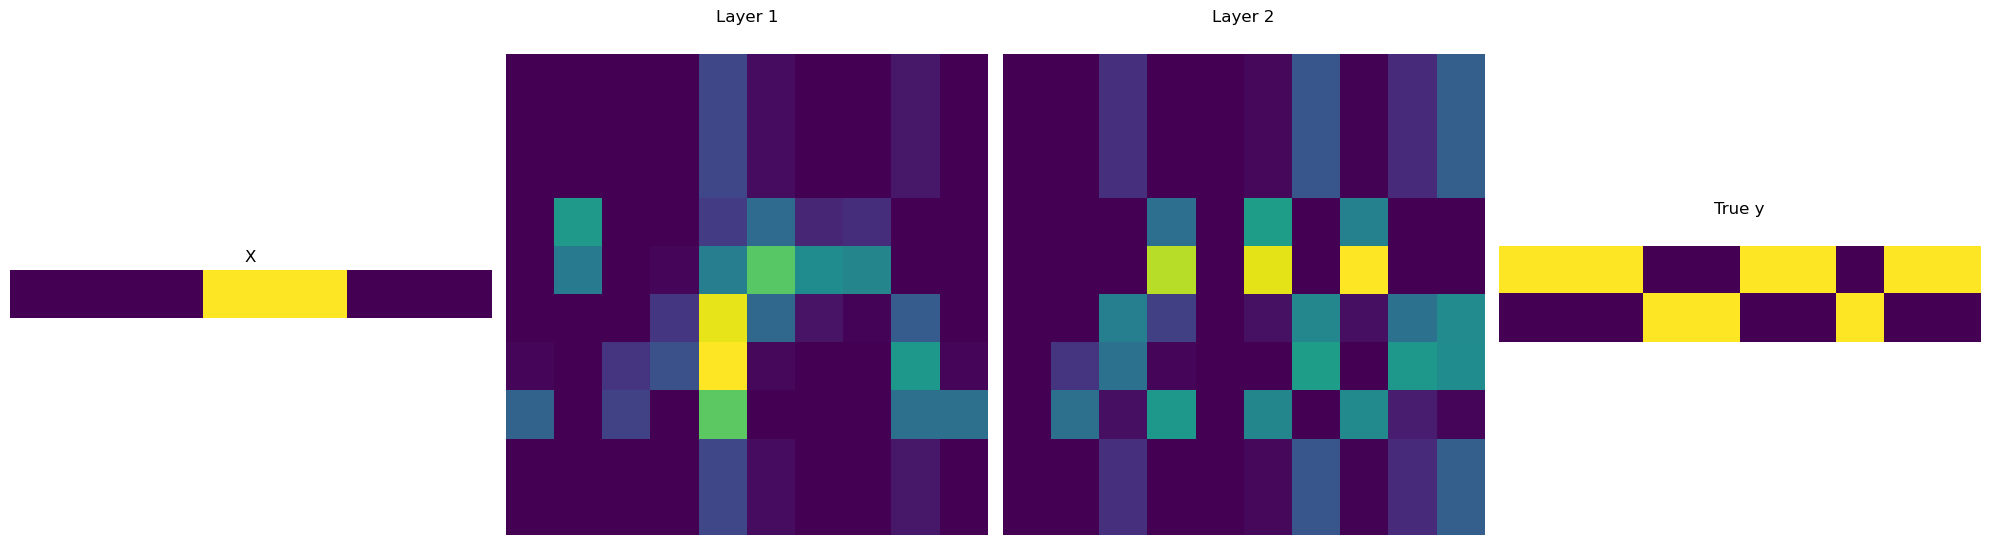

1/1 [==============================] - 0s 14ms/step
[[1 1 0 0 0 1 0 0 0 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


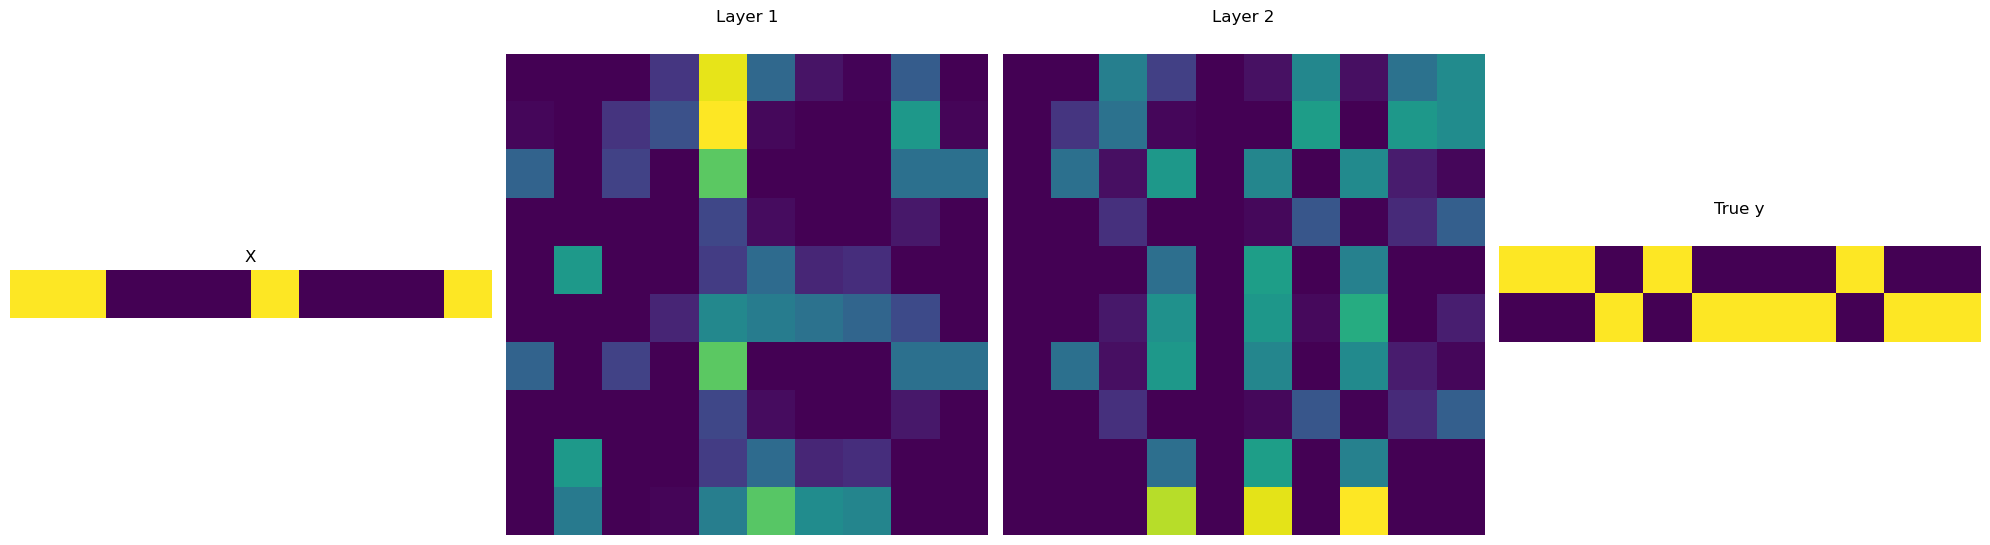

1/1 [==============================] - 0s 15ms/step
[[0 1 1 0 1 0 1 1 1 0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


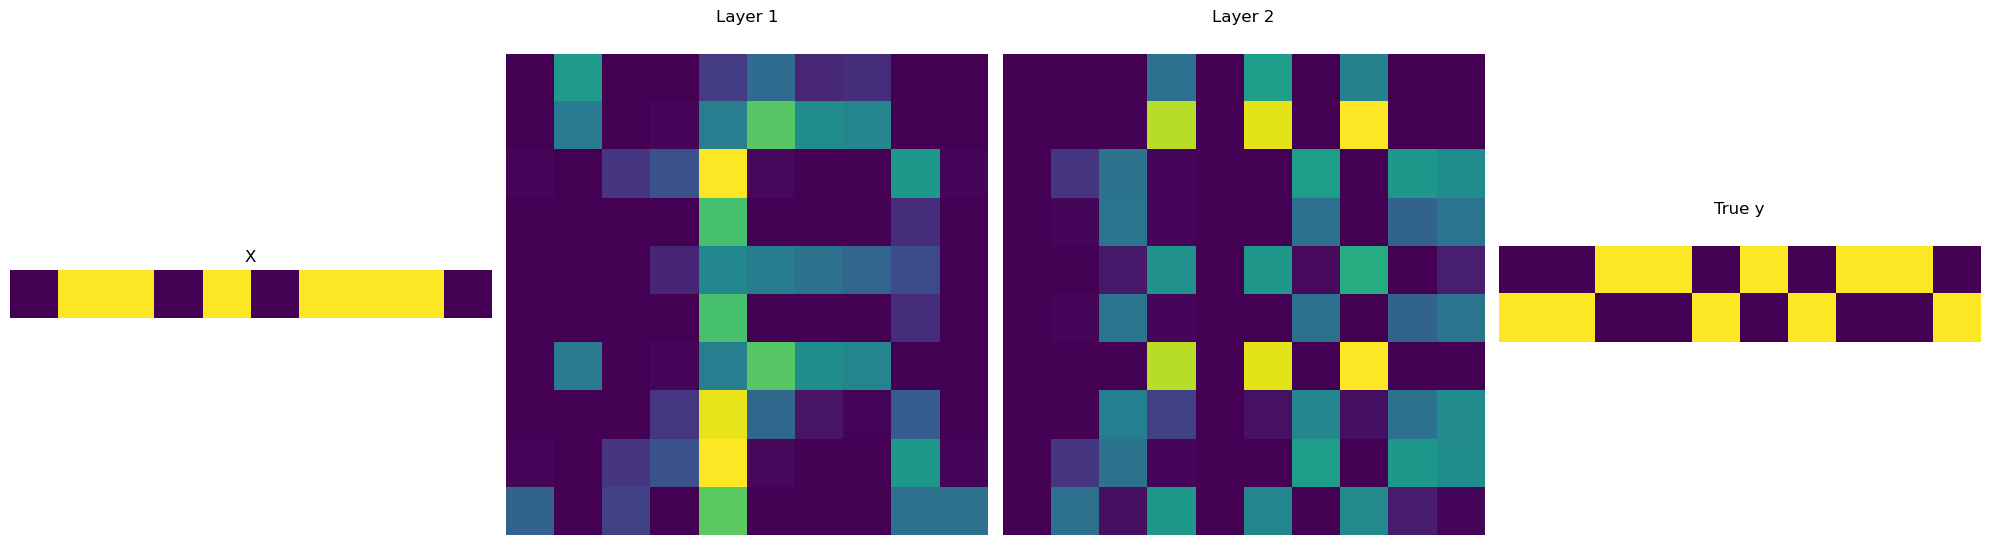

1/1 [==============================] - 0s 14ms/step
[[0 0 0 1 1 1 1 1 0 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


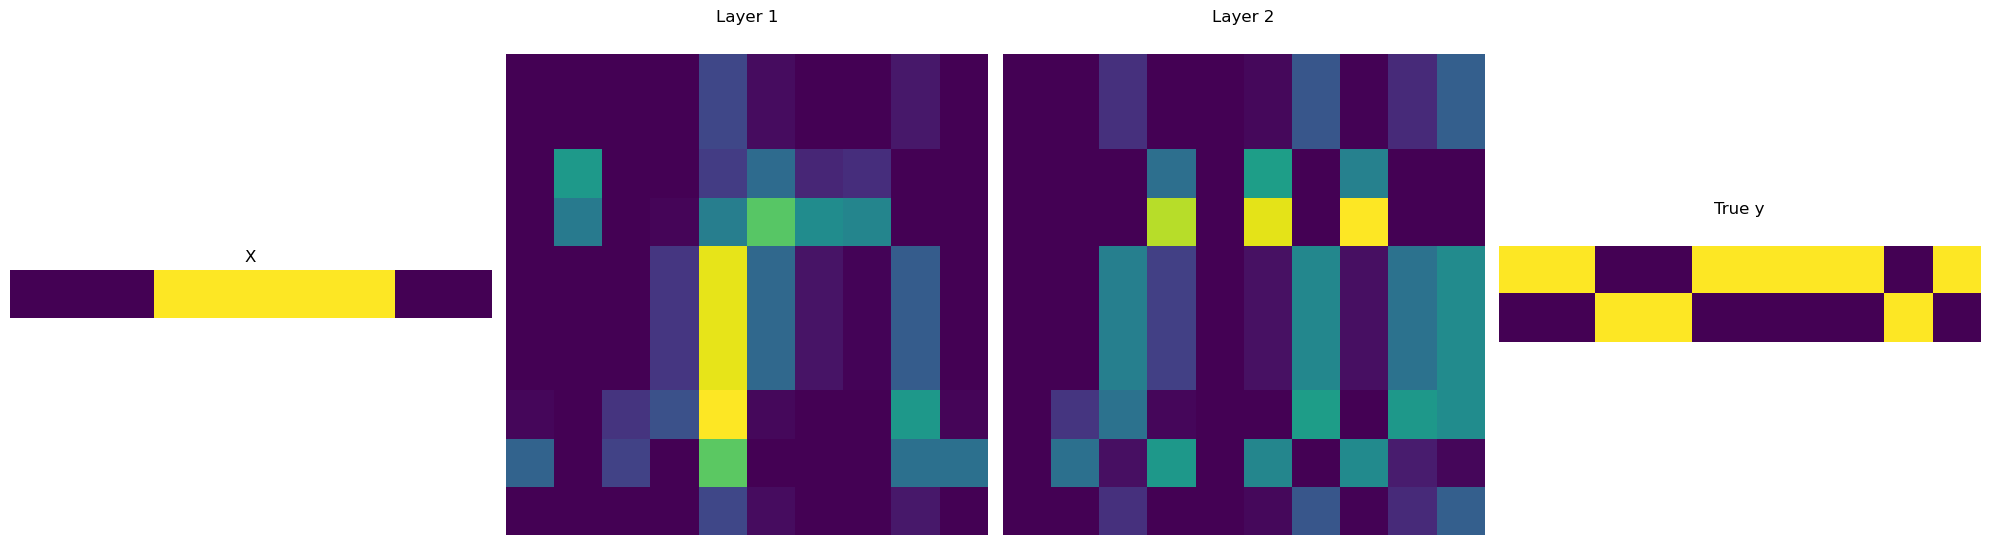

1/1 [==============================] - 0s 14ms/step
[[0 1 0 0 0 1 0 0 1 0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


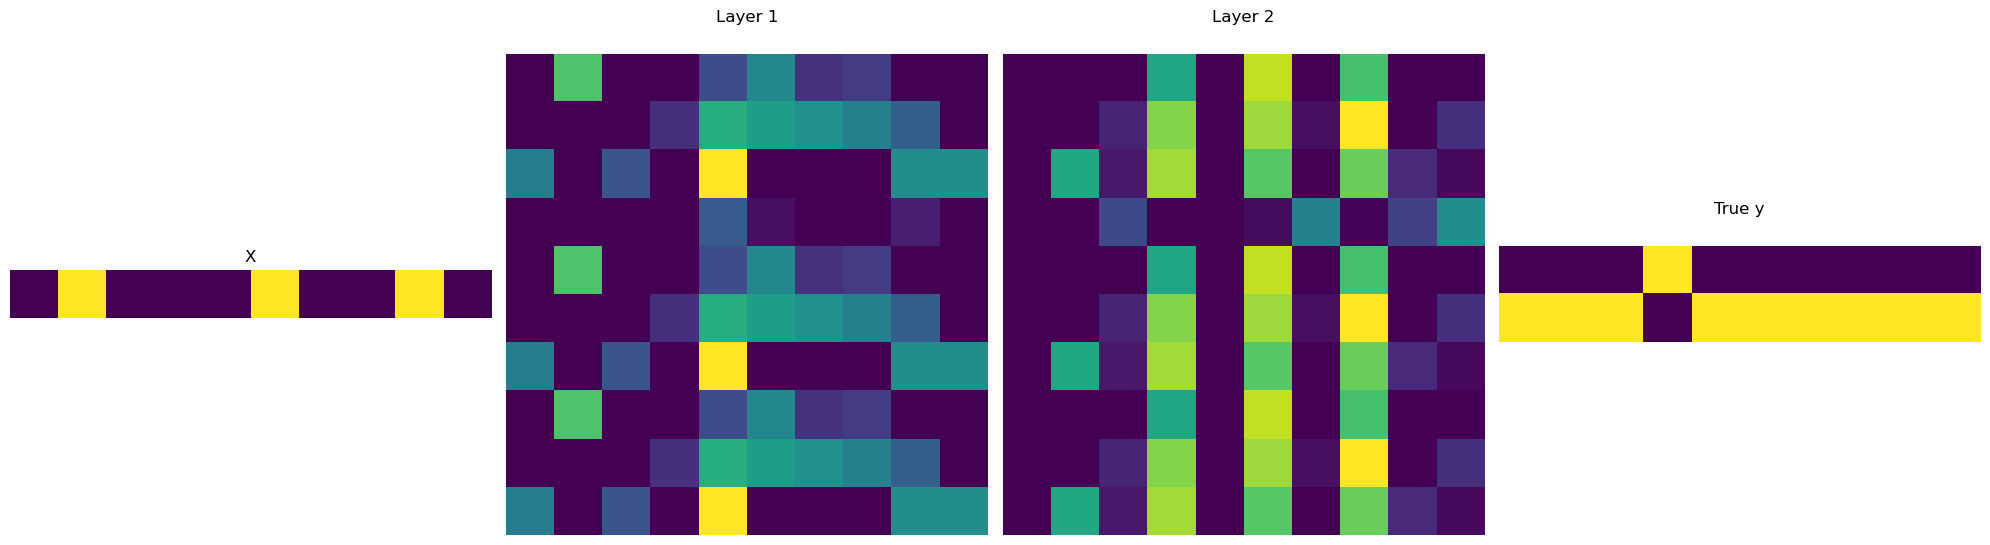

1/1 [==============================] - 0s 15ms/step
[[1 0 0 0 1 0 1 1 0 1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


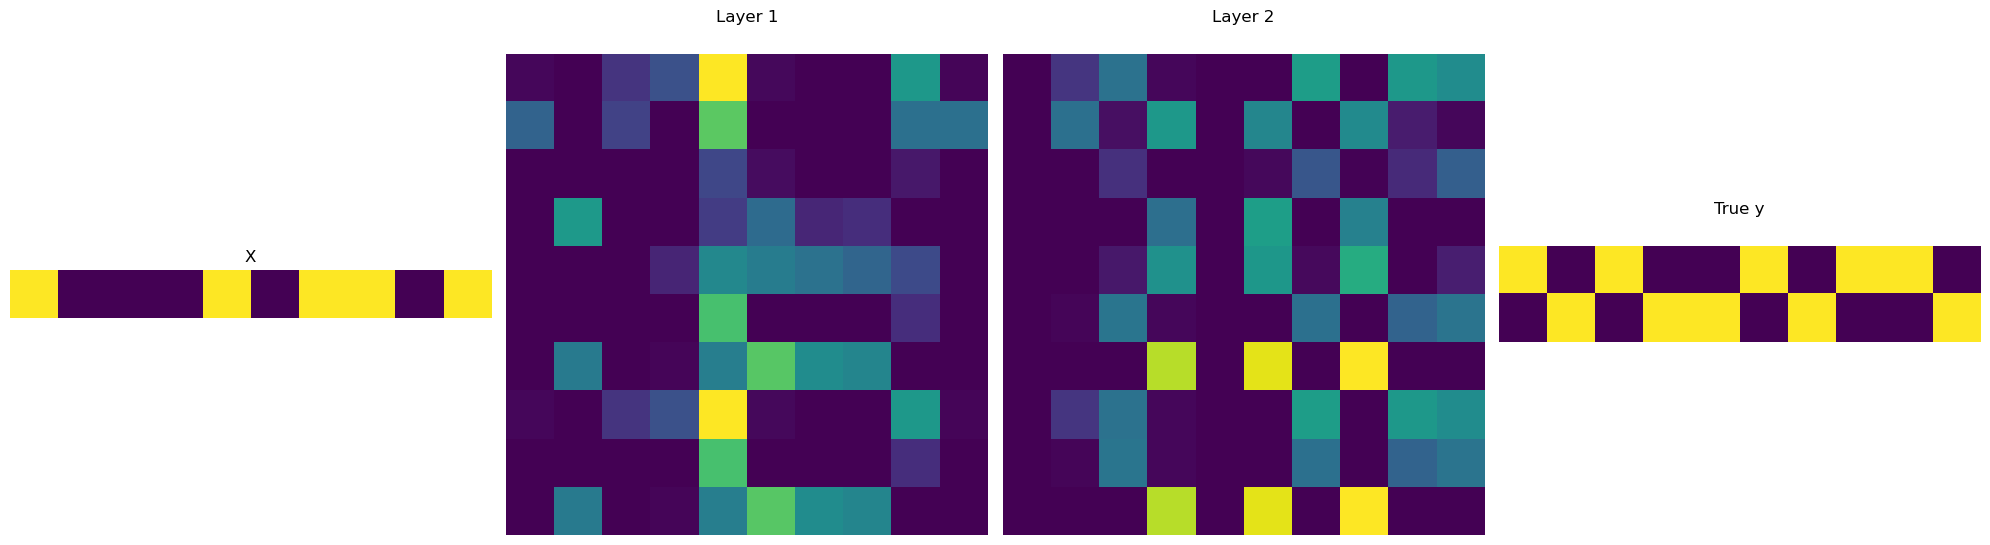

1/1 [==============================] - 0s 14ms/step
[[1 0 1 0 0 0 1 1 1 0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


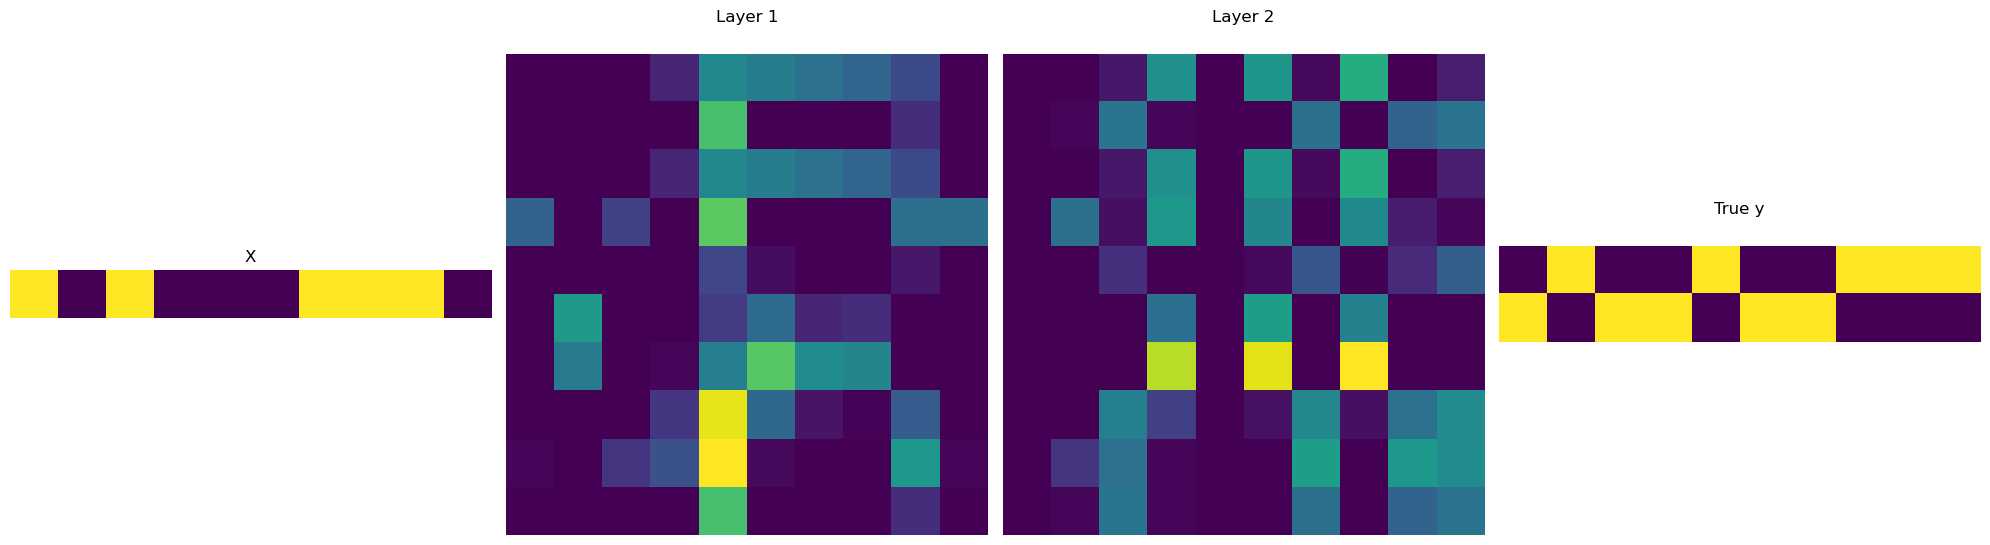

1/1 [==============================] - 0s 15ms/step
[[1 0 1 1 0 0 0 0 0 1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


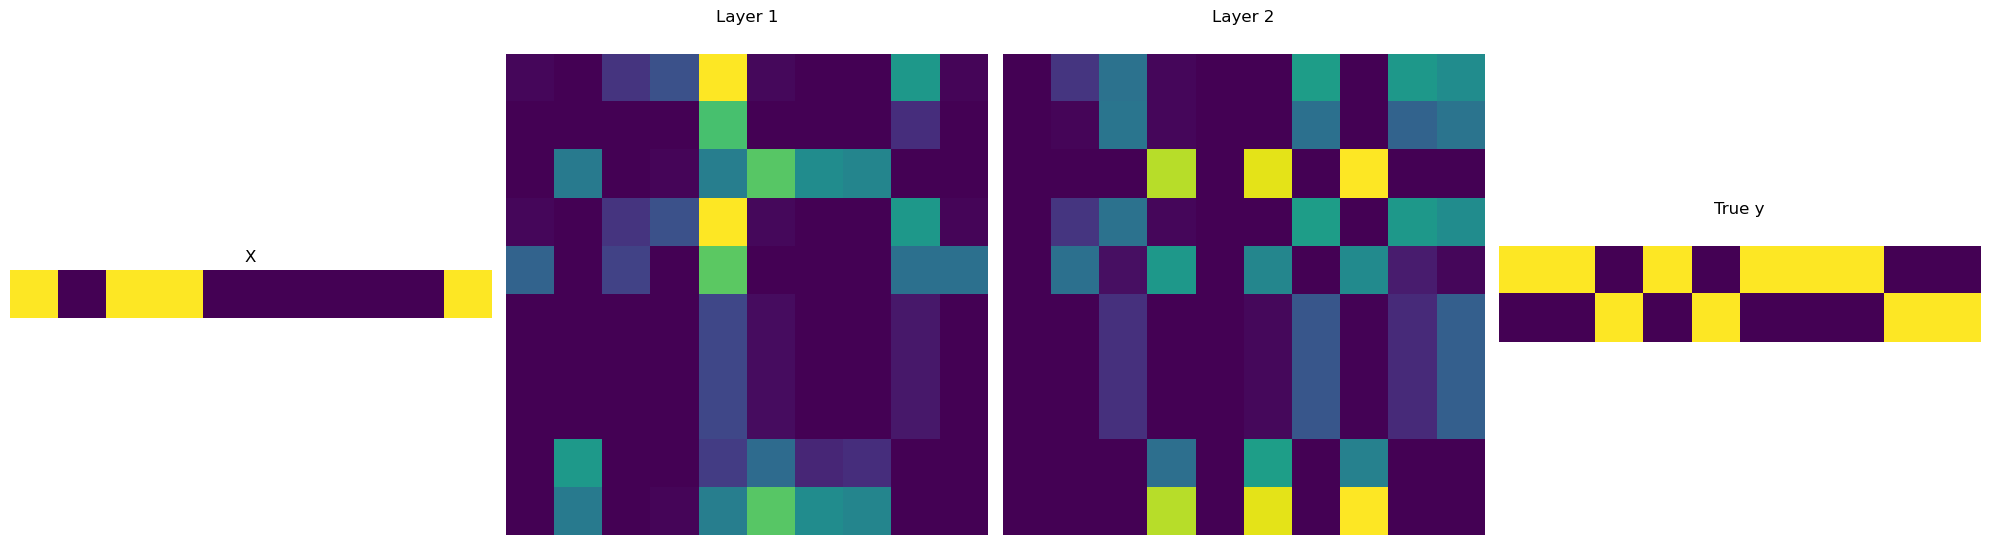

1/1 [==============================] - 0s 14ms/step
[[0 1 1 0 0 1 0 0 1 0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


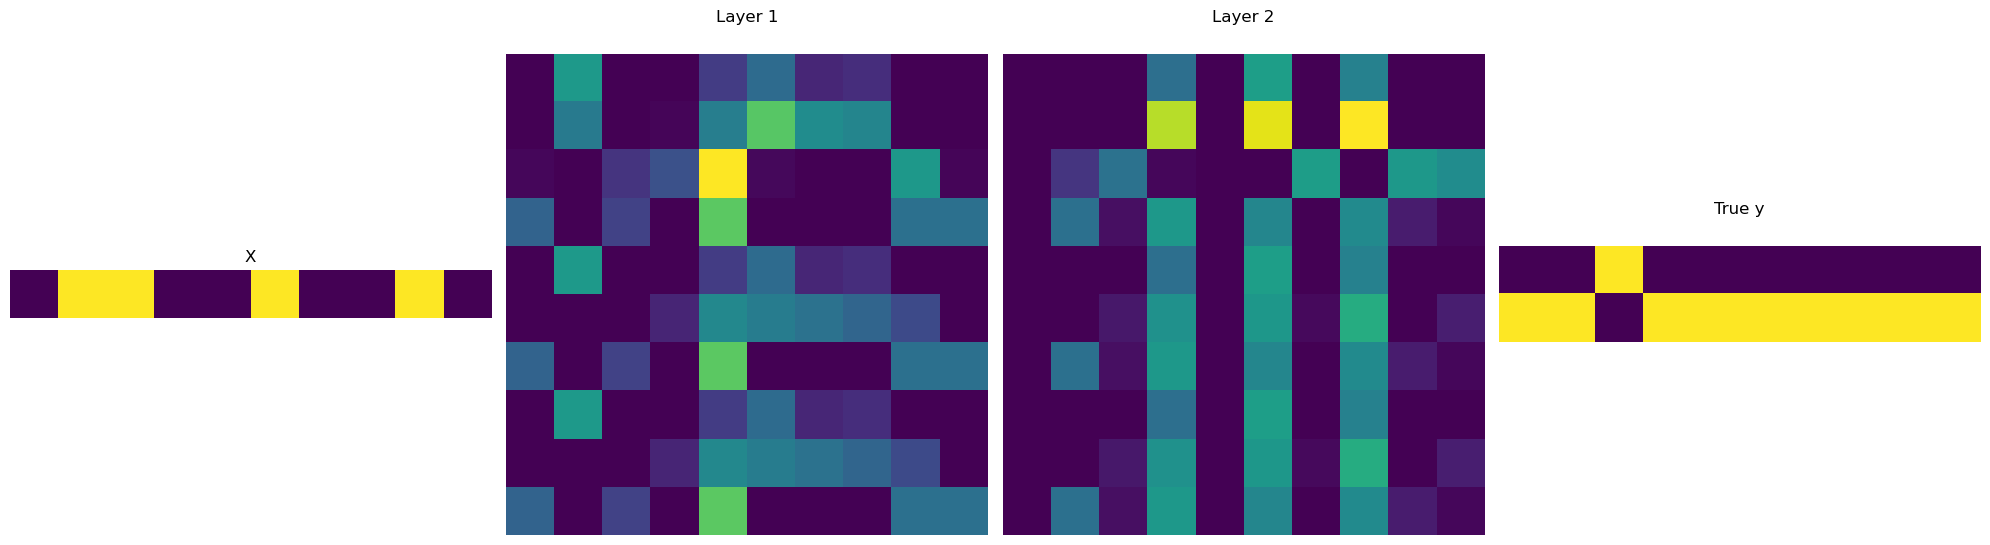

1/1 [==============================] - 0s 15ms/step
[[0 0 1 1 0 1 1 0 1 1]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


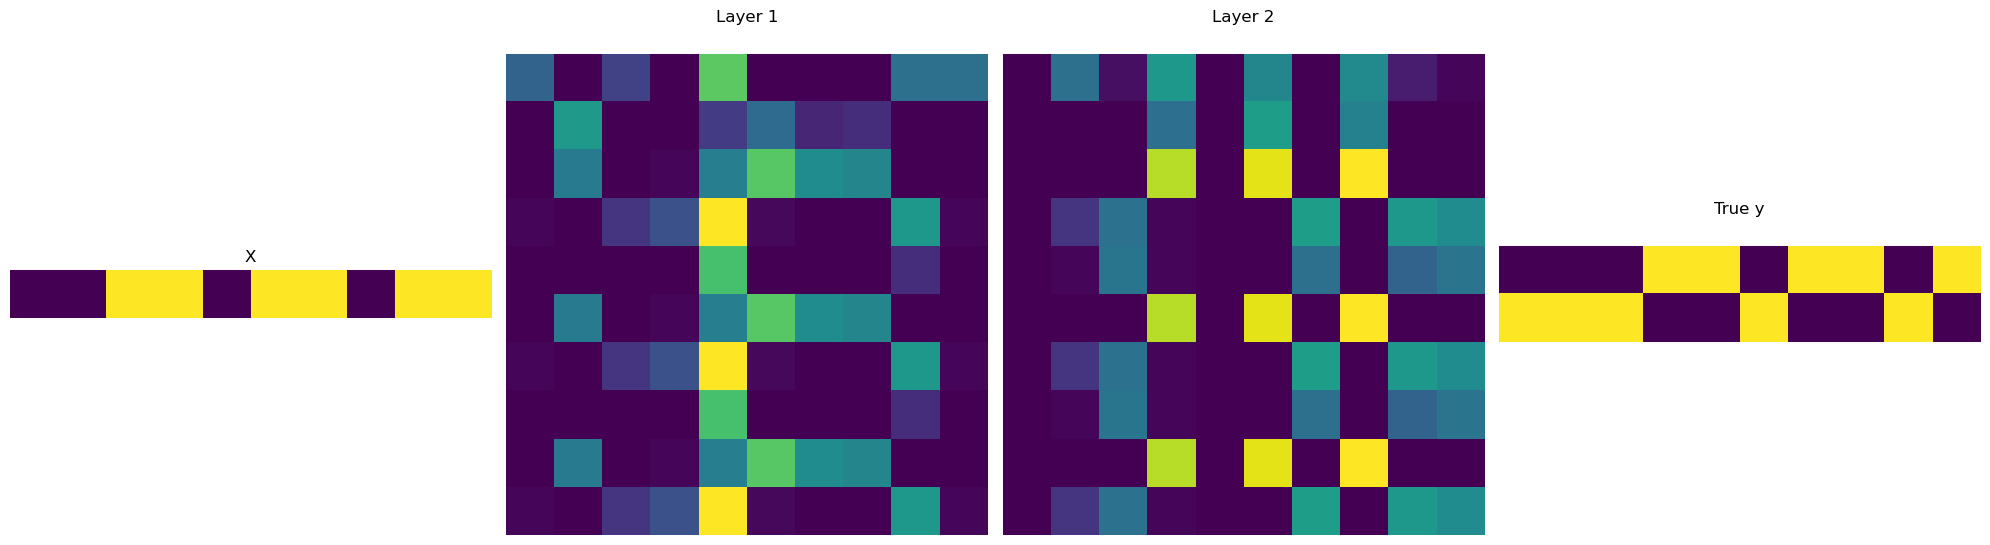

1/1 [==============================] - 0s 14ms/step
[[0 1 1 0 0 1 1 0 0 1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


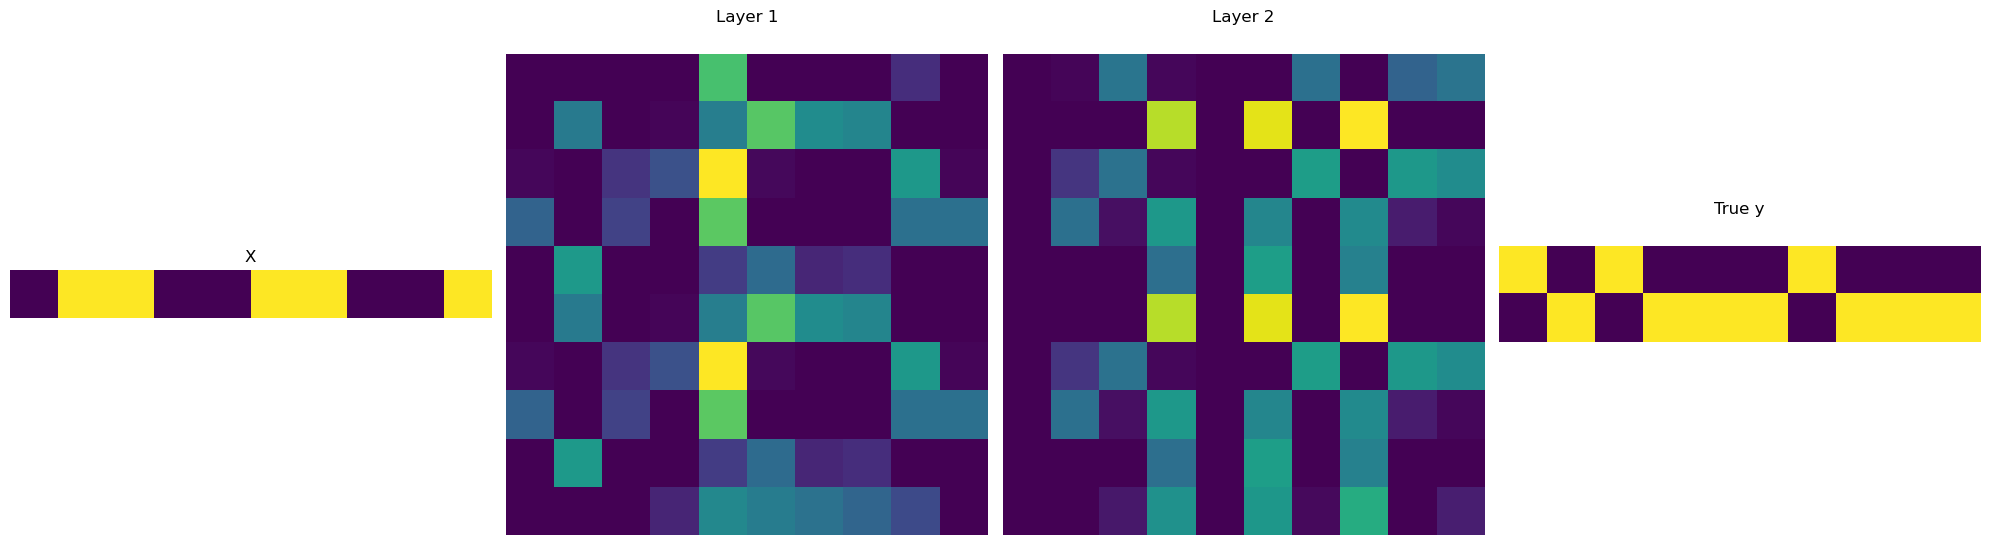

1/1 [==============================] - 0s 15ms/step
[[1 1 1 1 1 0 1 1 0 0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


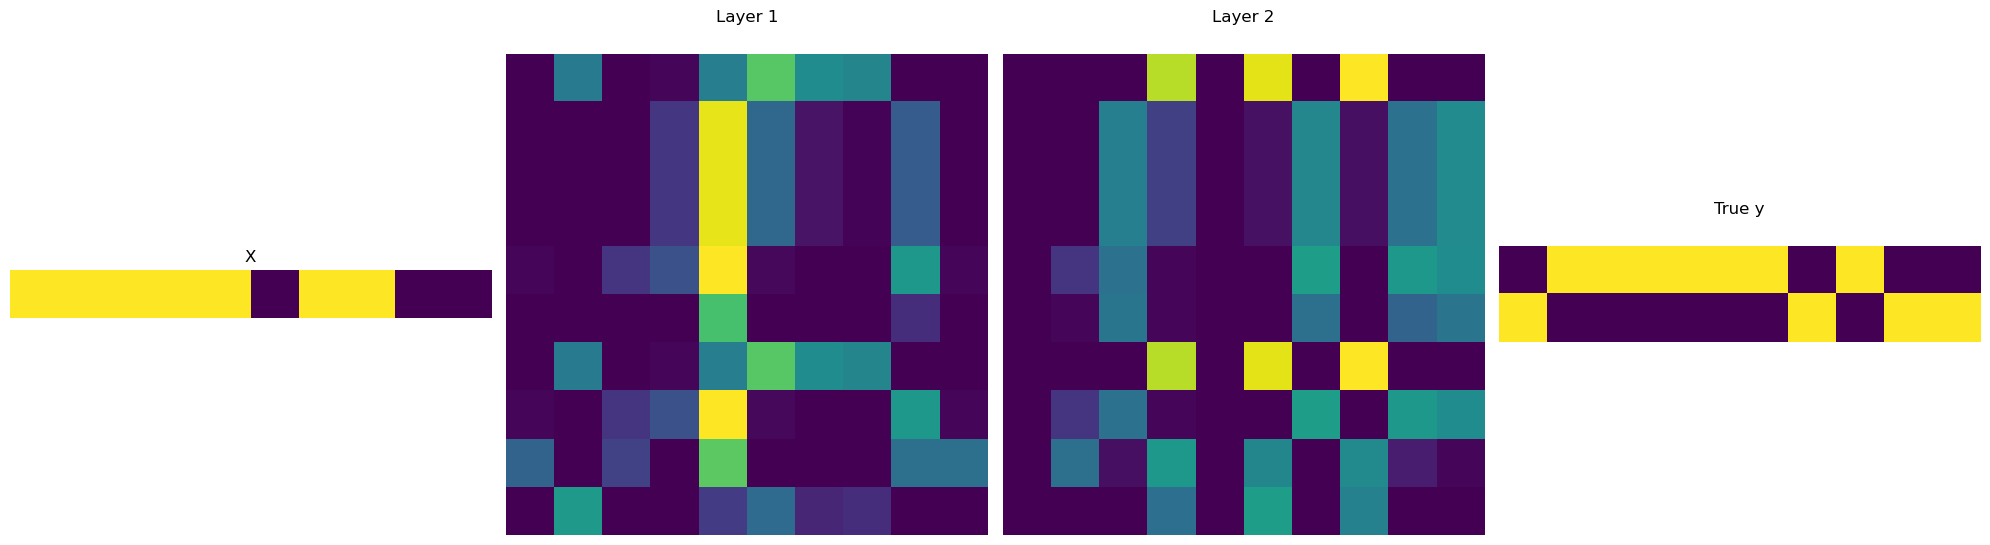

1/1 [==============================] - 0s 14ms/step
[[1 0 0 0 1 0 0 0 1 0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


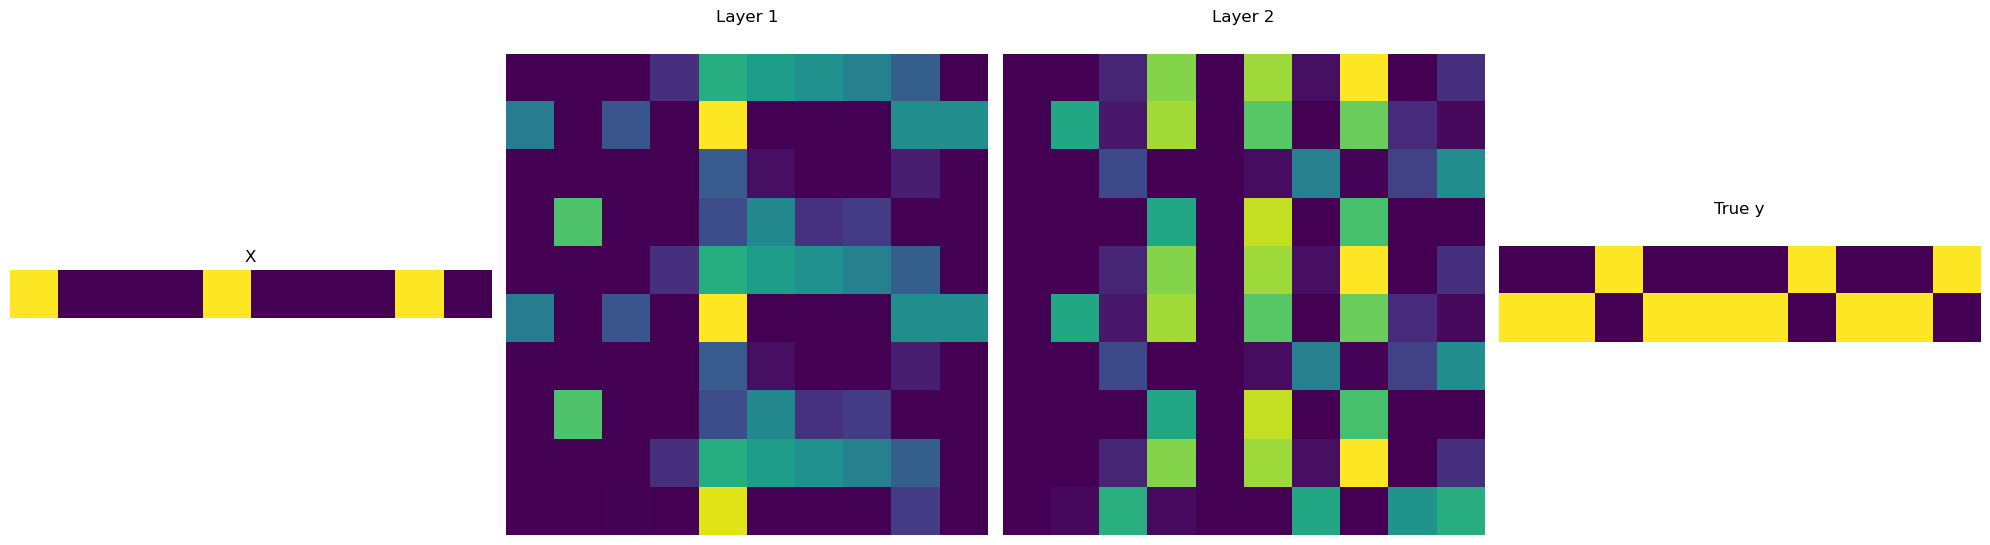

1/1 [==============================] - 0s 14ms/step
[[0 0 0 1 0 0 0 0 1 1]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


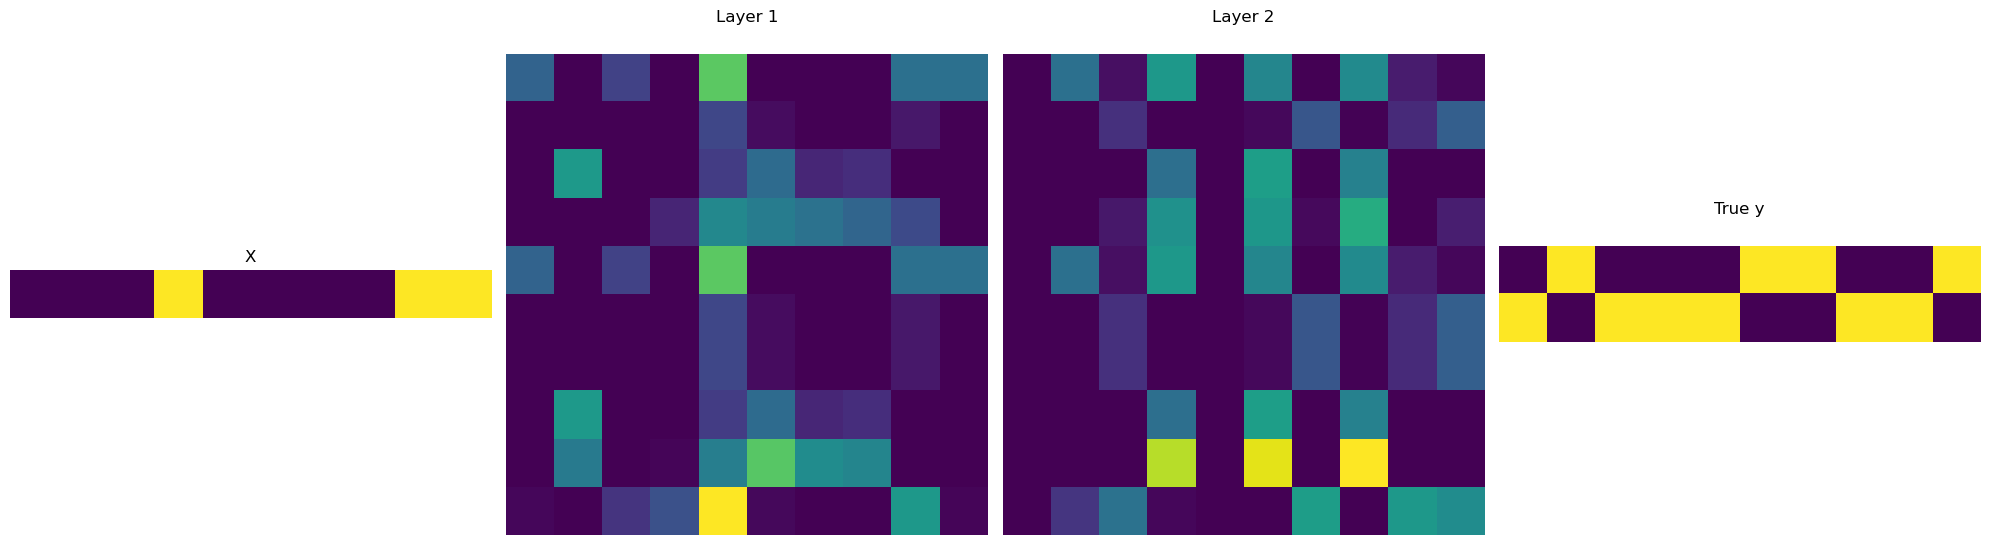

1/1 [==============================] - 0s 14ms/step
[[0 0 0 1 1 1 1 0 1 0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


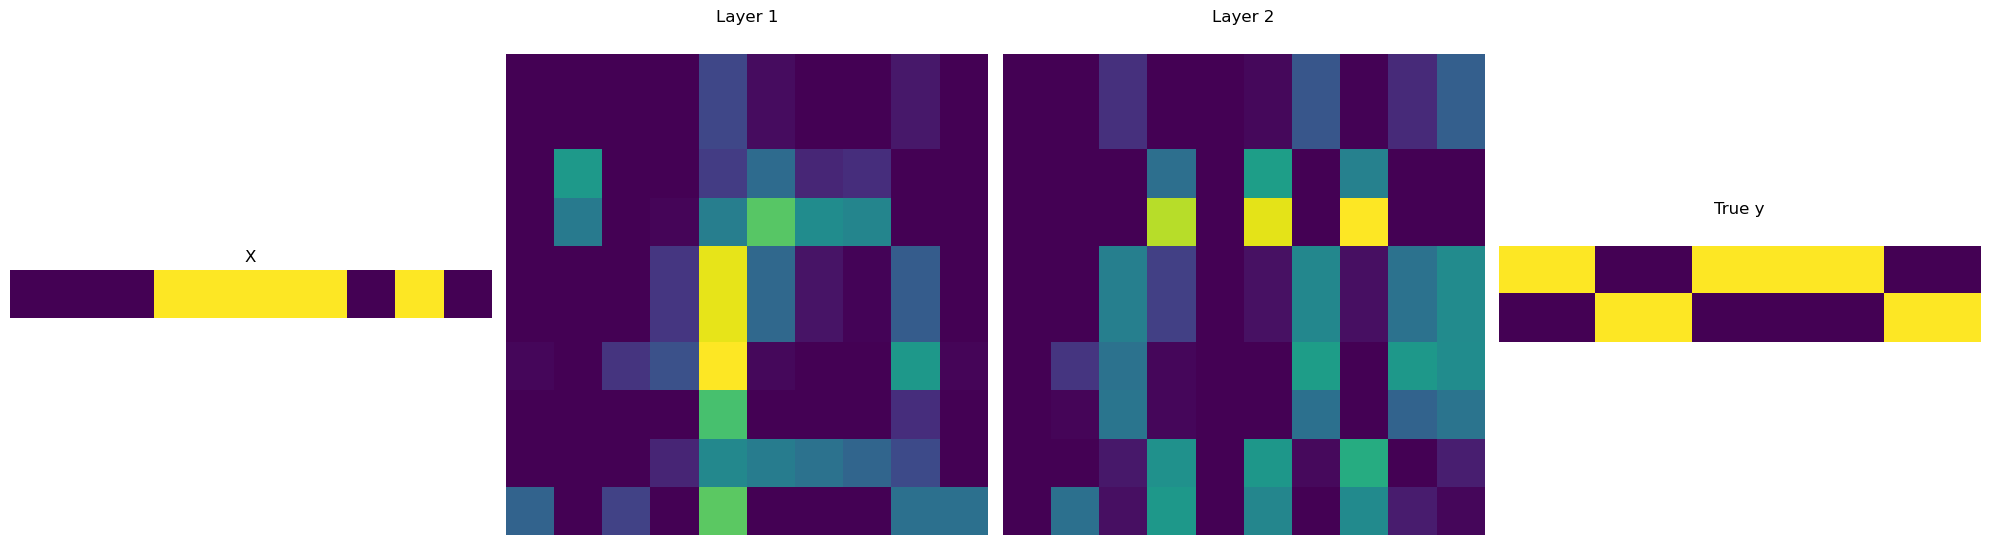

1/1 [==============================] - 0s 15ms/step
[[1 0 0 1 0 1 1 1 0 1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


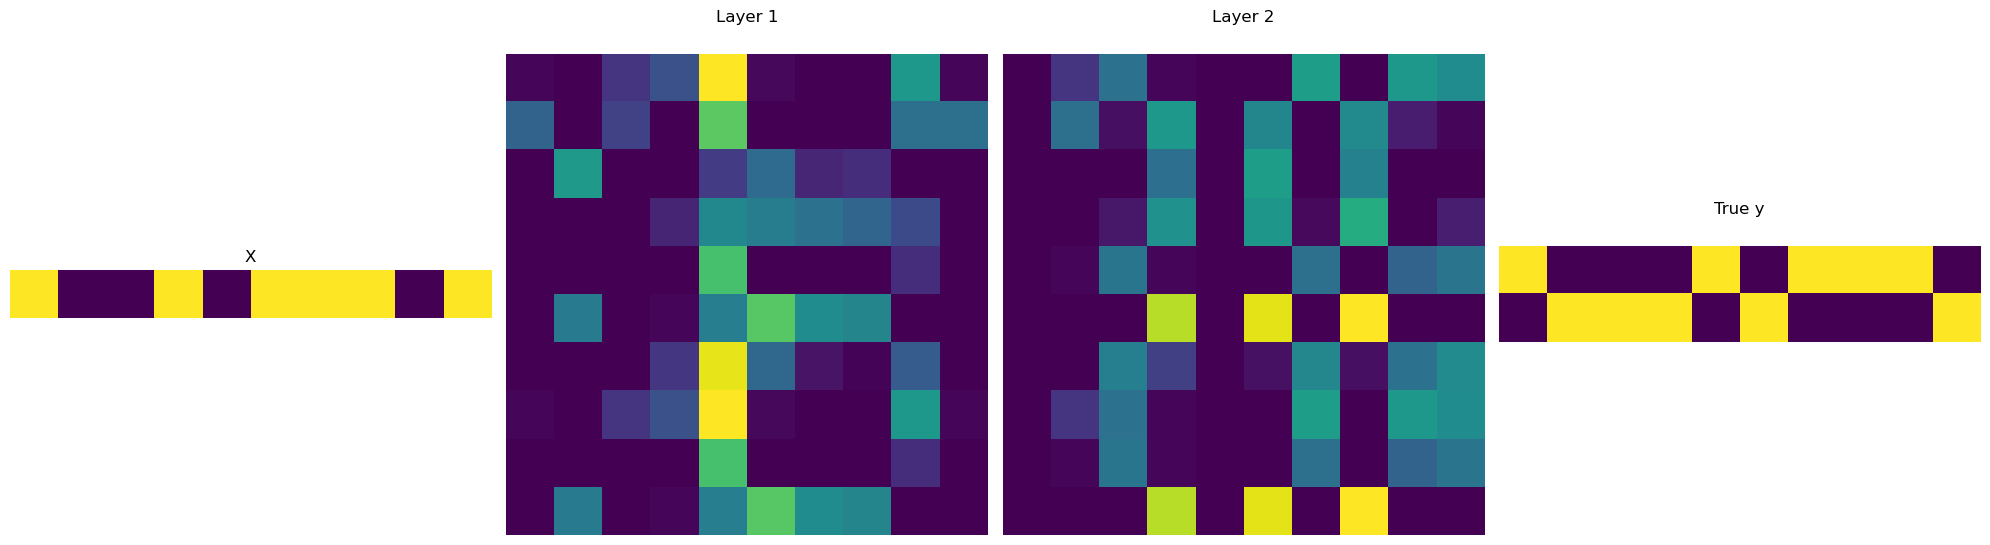

1/1 [==============================] - 0s 15ms/step
[[1 1 0 1 0 1 1 0 0 0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


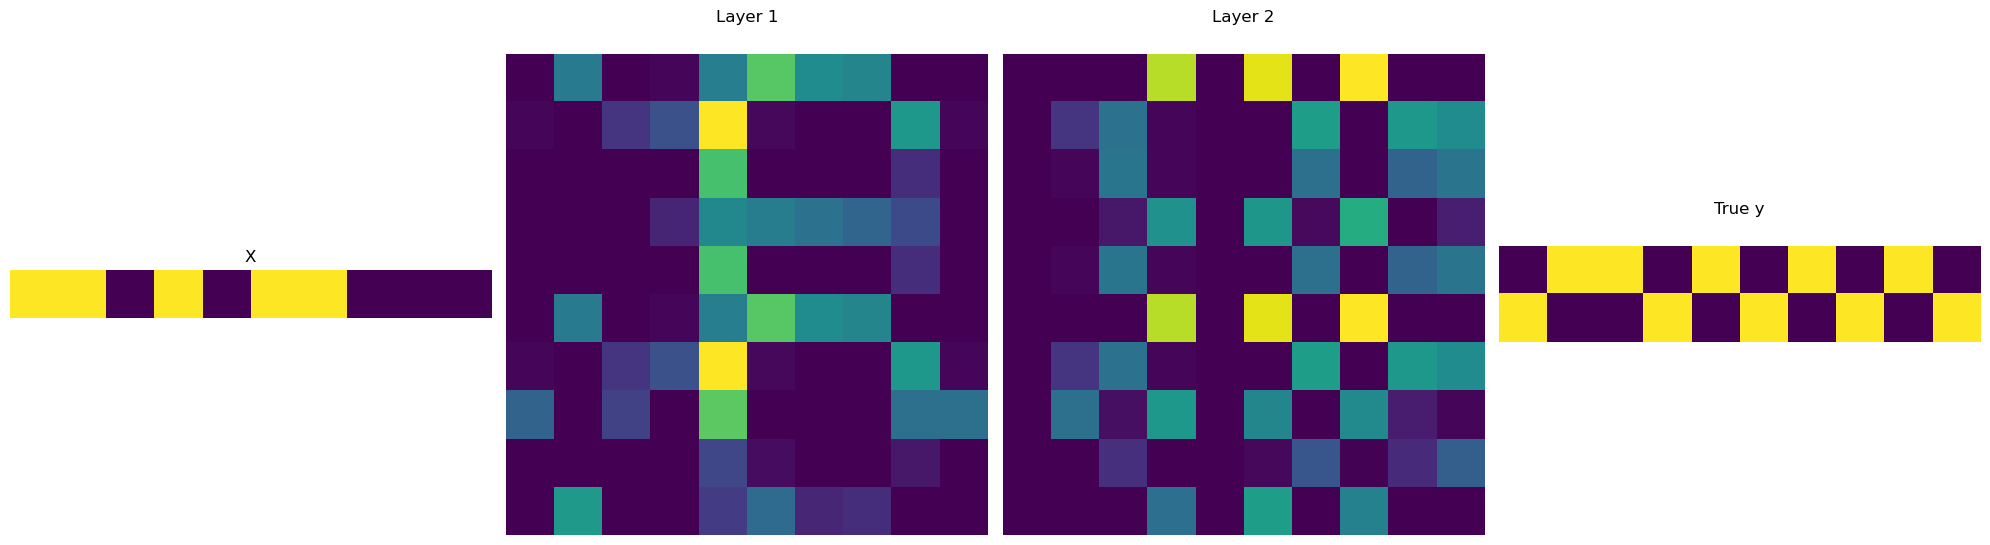

1/1 [==============================] - 0s 15ms/step
[[1 0 0 1 0 0 0 1 1 1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


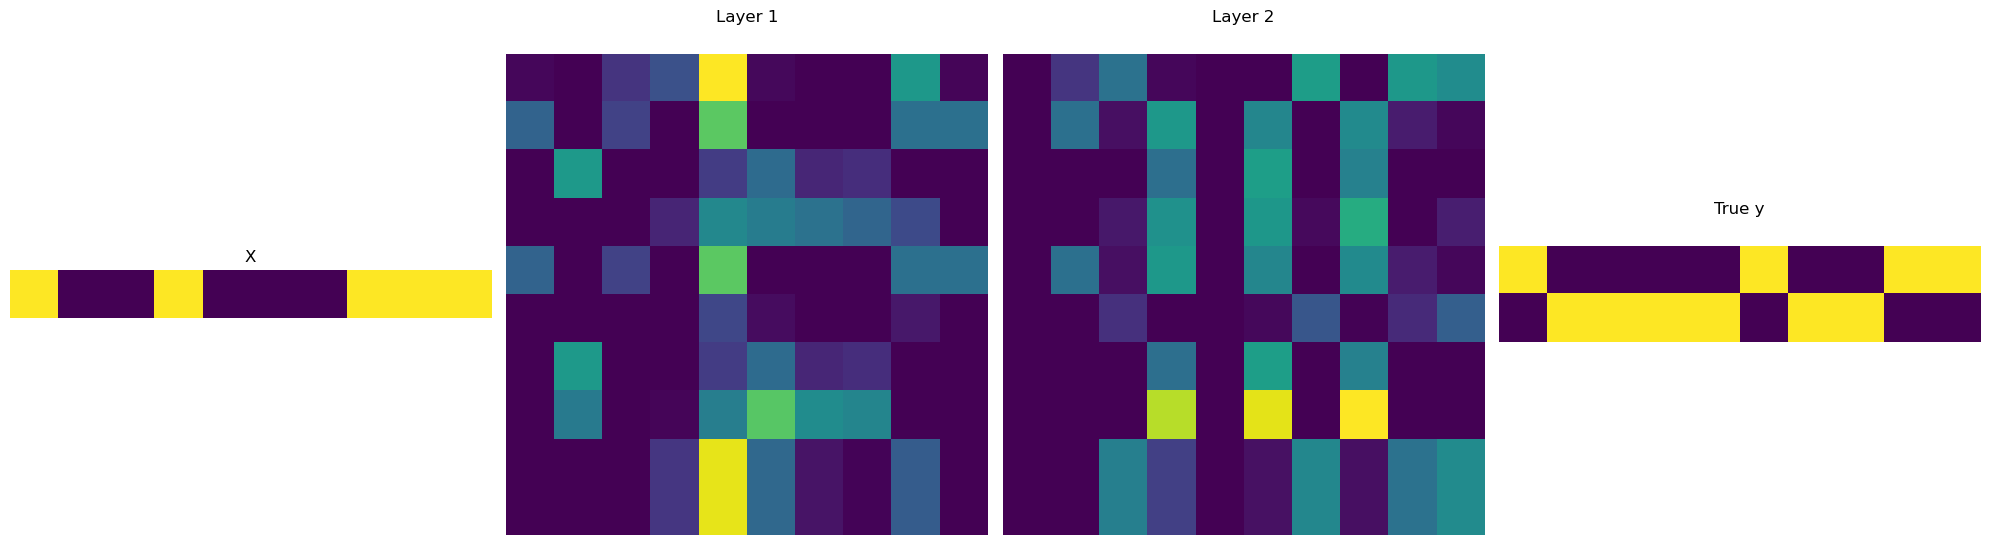

1/1 [==============================] - 0s 15ms/step
[[1 0 1 0 0 1 0 1 0 0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


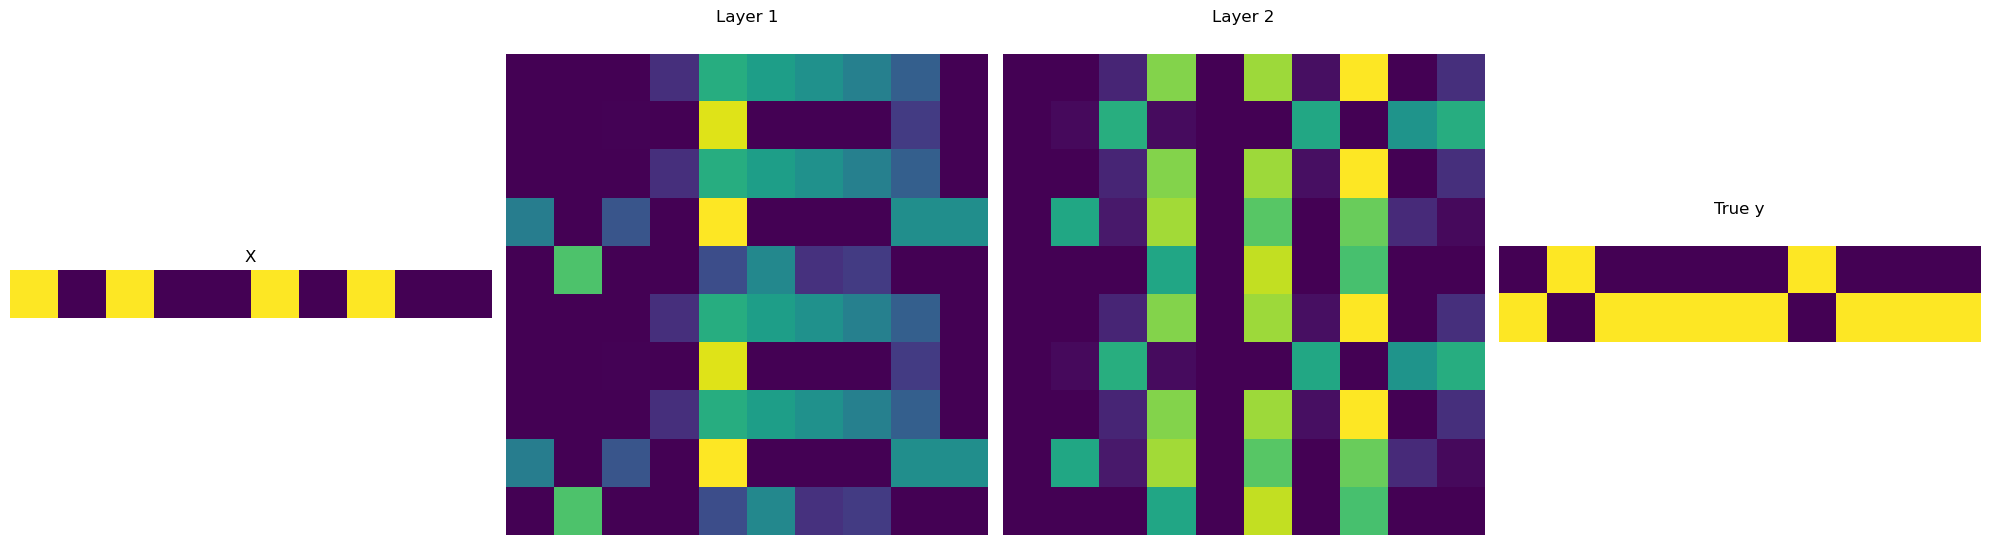

1/1 [==============================] - 0s 14ms/step
[[1 0 1 1 1 0 0 0 0 0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


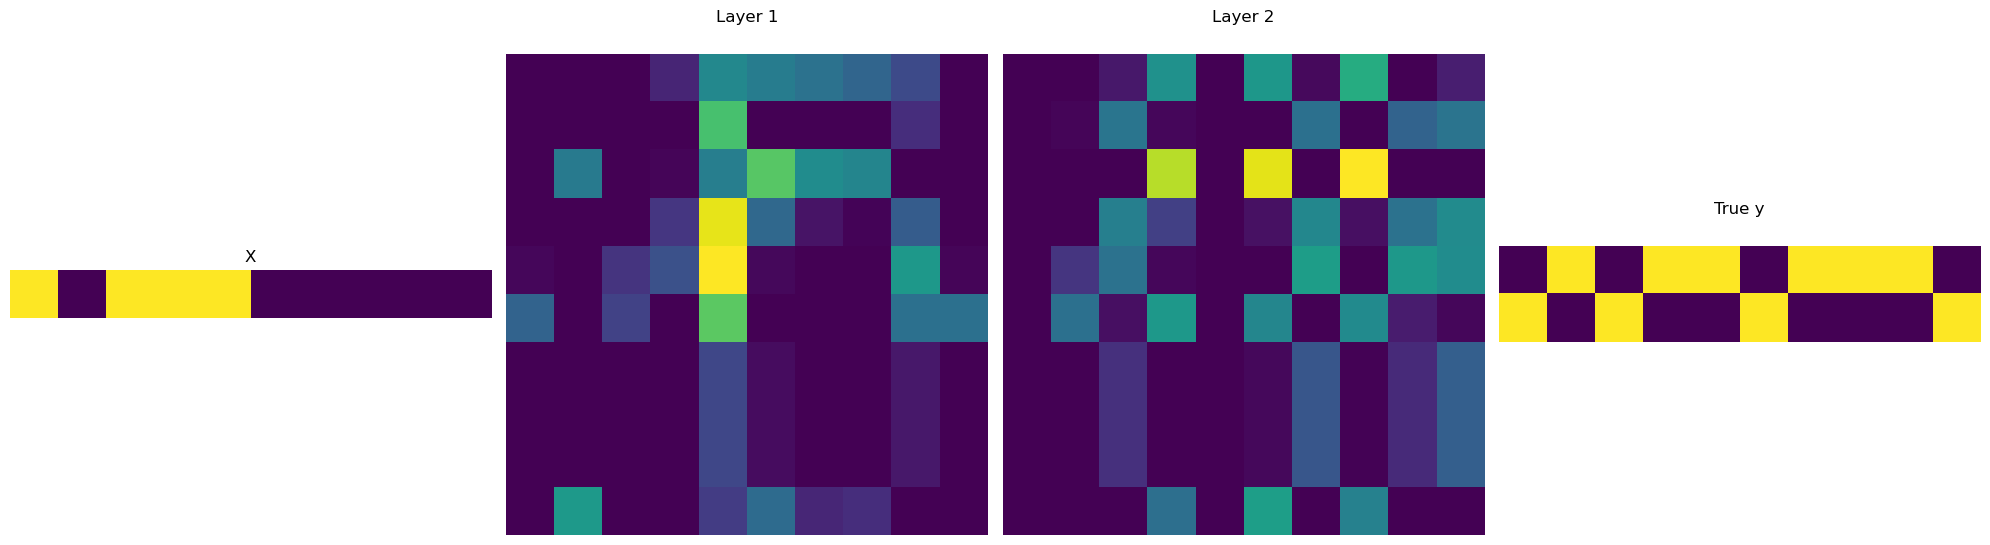

In [5]:
from tensorflow.keras.models import Model


 
conv_layer_outputs = [layer.output for layer in model.layers if "conv" in layer.name.lower()]

 
activation_model = Model(inputs=model.input, outputs=conv_layer_outputs)

for ind, x in enumerate(x_train_reshaped[0:20]):
    x_to_visualize = np.expand_dims(x, axis=0)

  
    activations = activation_model.predict(x_to_visualize)
 

 
    model_output =model.predict(x_to_visualize)
    # Create a subplot for input + last two activations + output
    num_layers = len(activations)
    fig, axes = plt.subplots(1,4, figsize=(20, 20))

    # Plot input
    axes[0].imshow(x_to_visualize[0, :].transpose(), cmap="viridis")
    axes[0].set_title("X")
    axes[0].axis("off")


    for i, activation in enumerate(activations[-2:]):
        ax = axes[i + 1]
        ax.matshow(activation[0, :, :], cmap="viridis")
        ax.set_title(f"Layer {num_layers - 1 + i}")
        ax.axis("off")
    print(x_train[ind])
    print(y_train[ind])
    axes[-1].matshow(np.array(y_train[ind]).transpose(), cmap="viridis")
    axes[-1].set_title("True y")
    axes[-1].axis("off")

    plt.tight_layout()

    #'plt.savefig("Ractivations" + str(ind) + ".png", dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:

for i in range (0,256):
    ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                    memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

    ca.set_rule_number(i)
    data=ca.generate_train_test_validation()
    x_train=data[0]
    y_train=data[1]
    x_val=data[2]
    y_val=data[3]
    x_test=data[4]
    y_test=data[5]
    memory_horizon=MEMORY_CONSTANT# is equal to 1
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  # Reshape input shape
    model.add(Wraparound1D(padding=1))
    model.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',  trainable=True) )

    model.add(tf.keras.layers.Conv1D(10, 1, activation='relu', padding='same'))

    model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                    kernel_initializer=tf.keras.initializers.Ones(), 
                                    bias_initializer=tf.keras.initializers.he_normal()))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
    model.summary()
    early_stopping_callback = CustomCallback()

    x_train_reshaped=x_train.reshape(-1, gridsize,1)
    model.fit(x_train_reshaped, y_train, 
              validation_data=(x_val.reshape(-1,gridsize,1 ), y_val),epochs=3
            , batch_size=1,callbacks=[early_stopping_callback]) 
    eval=model.evaluate(x_test.reshape(-1, gridsize,1),y_test)
        

In [16]:
y_sequence.shape
x_sequence=x_sequence.reshape(-1,10)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


param_grid = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 100],
    'min_samples_leaf': [1, 2, 4,8, 20]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, verbose=1)
grid_search.fit(x_sequence[0:700], y_sequence[0:700])
best_tree = grid_search.best_estimator_
predictions = best_tree.predict(x_sequence[700:])
accuracy = accuracy_score(y_sequence[700:], predictions)
print(f"Optimized Model Accuracy: {accuracy}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimized Model Accuracy: 0.015432098765432098


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, verbose=1)
grid_search_rf.fit(x_sequence[0:700], y_sequence[0:700])
best_rf = grid_search_rf.best_estimator_
rf_predictions = best_rf.predict(x_sequence[700:])
rf_accuracy = accuracy_score(y_sequence[700:], rf_predictions)
print(f"Optimized Random Forest Model Accuracy: {rf_accuracy}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Optimized Random Forest Model Accuracy: 0.8858024691358025


In [19]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(12, 20), max_iter=500)
mlp.fit(x_sequence[0:700], y_sequence[0:700])

mlp_predictions = mlp.predict(x_sequence[700:])
mlp_accuracy = accuracy_score(y_sequence[700:], mlp_predictions)
print(f"Neural Network Model Accuracy: {mlp_accuracy}")


Neural Network Model Accuracy: 0.5987654320987654


C:\Users\DScie\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:

gridsize=149
x_values = [seq for seq in itertools.product("01", repeat=10)]
x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=6
 
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT,initial_state=x_values)

ca.set_rule([[[0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1]],
              [[0],      [1]         ,[1]      ,[1]     ,[1]      ,[0]      ,[0],     [0 ]]])

ca.step_multiple(149)
ca.render_state()
ca.plot_evolultion()
ca.savefig('rule300.png')